<a href="https://colab.research.google.com/github/davidegavio/amd-sm2l-project/blob/main/amd_sm2l_project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Joint project AMD - SM2L
Davide Gavio - 930569





# Important disclaimer
When an operation modifies datasets, there are some lines of codes that show to the user some information about the resulting dataset. This could lead to some slowdown in the code execution. For a faster execution it's necessary to uncomment all those informative lines of code (count(), show(), ecc. calls).

# Google Colab settings
Those actions need to be done in order to have the notebook working on Google Colab. 
If the notebook is executed elsewhere skip to the next cell.


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz   
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark pyspark seaborn kaggle scikit-learn matplotlib pandas progressbar2
!rm spark-3.0.1-bin-hadoop2.7.tgz
with open('/content/spark-3.0.1-bin-hadoop2.7/conf/spark-defaults.conf', 'w') as file_object:
  file_object.write('spark.driver.memory              15g')
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

     |████████████████████████████████| 204.2MB 73kB/s 
     |████████████████████████████████| 204kB 48.6MB/s 


# PySpark settings


In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('amd-sm2l-project').master("local[*]").getOrCreate()

# Imports and settings


In [3]:
!mkdir ~/.kaggle
!echo '{"username":"davidegavio","key":"f4540434f20370f2bf34e2f9010b647e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
from matplotlib.pyplot import xlabel, ylabel
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType, Row
from pyspark.context import SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, MinMaxScaler, OneHotEncoder, VectorAssembler, StringIndexer, StandardScaler
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.regression import LabeledPoint, RidgeRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import ChiSqSelector, VectorIndexer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from zipfile import ZipFile
import os
from datetime import datetime
from pyspark.sql.types import *
import math
import kaggle

In [5]:
learning_rate = 0.00001
n_iterations = 150
lowest_error = float('inf')
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1, 10, 100, 1000]
alpha = 0.01
num_partitions = spark.sparkContext.defaultParallelism * 3

In [6]:
print('Parallelism info')
print("Default parallelism: {}".format(spark.sparkContext.defaultParallelism))
print("Custom parallelism: {}\n".format(num_partitions))

Parallelism info
Default parallelism: 2
Custom parallelism: 6



# Ridge Regression


In [7]:
import numpy as np 
import math
from datetime import datetime
from pyspark.sql import SparkSession
from progressbar import ProgressBar
 
 
 
class SparkRidgeRegression(object):
    """ Base regression model. Models the relationship between a scalar dependent variable y and the independent 
        variables X. 
        Parameters:
        -----------
        n_iterations: float
            The number of training iterations the algorithm will tune the weights for.
        learning_rate: float
            The step length that will be used when updating the weights."""
    def __init__(self, n_iterations, learning_rate, reg_factor):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.reg_factor = reg_factor
    
    def get_training_errors(self):
        return self.training_errors
    
    def set_training_errors(self, error):
        self.training_errors = error
 
    def squared_error(self, target, prediction):
        return (target - prediction) ** 2
 
    def root_mean_squared_error(self, predictions):
        return np.sqrt(predictions.map(lambda p: self.squared_error(*p)).mean())
 
    def mean_squared_error(self, predictions):
        return predictions.map(lambda p: self.squared_error(p[0], p[1])).mean()
 
    def mean_absolute_error(self, predictions):
        return np.abs(predictions.map(lambda prediction: prediction[1] - prediction[0]).reduce(lambda a, b: a + b))/predictions.count()
    
    def r2(self, predictions):
        mean_ = predictions.rdd.map(lambda t: t[0]).mean()
        sum_squares = predictions.rdd.map(lambda t: (t[0] - mean_)**2).sum()
        residual_sum_squares = predictions.rdd.map(lambda t: self.squared_error(*t)).sum()
        return 1 - (residual_sum_squares / sum_squares)
 
 
    def get_grad_sum(self, example):
        return (self.weights.dot(DenseVector(example.features)) - example.label) * example.features
 
    
    def fit(self, observations):
        progressbar = ProgressBar()
        features_number = len(observations.take(1)[0].features)
        self.training_errors = []
        self.weights = np.zeros(features_number)        
        start = datetime.now()
        # Do gradient descent for n_iterations
        for i in progressbar(range(self.n_iterations)):
          # Get the prediction given an example and the current weights
          predictions = observations.map(lambda example: self.predict(example)) # Result [label, prediction]
          # Calculate l2 loss
          regularization = self.reg_factor * self.weights
          self.training_errors.append(self.root_mean_squared_error(predictions))
          # Gradient of l2 loss w.r.t w
          grad_w = observations.map(lambda example: DenseVector(self.get_grad_sum(example))).reduce(lambda x, y: x + y) + regularization
          # Update the weights
          self.weights -= self.learning_rate * grad_w
          if i == self.n_iterations-1:
            float_predictions = predictions.map(lambda xs: [float(x) for x in xs])
            predictions_df = float_predictions.toDF(['label', 'predictions'])
            print('From scratch training MSE: {}'.format(self.mean_squared_error(predictions=predictions)))
            print('From scratch training RMSE: {}'.format(self.root_mean_squared_error(predictions=predictions)))
            print('From scratch training MAE: {}'.format(self.mean_absolute_error(predictions=predictions)))
            print('From scratch training R2: {}'.format(self.r2(predictions_df)))
 
    def predict(self, example):
        return (example.label, self.weights.dot(DenseVector(example.features)))

# Utilities

In [8]:
def to_labeledpoint(row):
  row_dict = row.asDict()
  target = np.array(row_dict['scaled_target'][0])
  features = np.array(row_dict['scaled_features']).tolist()
  features.insert(0, 1.0)
  return LabeledPoint(target, features)
 
def remove_outliers(df):
  quantiles = df.approxQuantile(label_to_predict, [0.25, 0.75], 0.1)
  iqr = quantiles[1] - quantiles[0]
  if iqr != 0:
    df = df.filter(f.col(label_to_predict).between(quantiles[0] - (1.5 * iqr), quantiles[1] + (1.5 * iqr)))
  return df

# Dataset download

In [9]:
print('Downloading necessary files from Kaggle')
startTime = datetime.now()
kaggle.api.authenticate()
!mkdir ~/.kaggle
!echo '{"username":"davidegavio","key":"f4540434f20370f2bf34e2f9010b647e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!mkdir ./datasets
!kaggle datasets download census/2013-american-community-survey -p ./datasets
with ZipFile('./datasets/2013-american-community-survey.zip', 'r') as zipObj:
   zipObj.extractall('./datasets/2013-american-community-survey')
os.remove('./datasets/2013-american-community-survey.zip')
print('Your download has been completed in: {}'.format(datetime.now() - startTime))

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 905M/916M [00:15<00:00, 51.9MB/s]
100% 916M/916M [00:15<00:00, 63.5MB/s]
Your download has been completed in: 0:01:09.982828


# Preprocessing

In [10]:
%%time
print('Reading from csv')
df_a = spark.read.csv('/content/datasets/2013-american-community-survey/ss13pusa.csv', inferSchema=True, header=True).limit(35000)
df_b = spark.read.csv('/content/datasets/2013-american-community-survey/ss13pusb.csv', inferSchema=True, header=True).limit(35000)
df = df_a.union(df_b)
df = df.repartition(numPartitions=num_partitions)
label_to_predict = 'WAGP'
drop_thresh = .66
print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")
print('The dataframe is divided in {} partitions'.format(df.rdd.getNumPartitions()))
print('==> Done\n')

Reading from csv
The shape is 70000 rows by 283 columns.
The dataframe is divided in 6 partitions
==> Done

CPU times: user 257 ms, sys: 33.9 ms, total: 291 ms
Wall time: 1min 55s


In [11]:
df.describe().show()

+-------+-----+------------------+------------------+------------------+------------------+---------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-----

In [12]:
df.select(label_to_predict).describe().show()

+-------+------------------+
|summary|              WAGP|
+-------+------------------+
|  count|             58107|
|   mean|20750.508716677854|
| stddev| 37349.73921337099|
|    min|                 0|
|    max|            327000|
+-------+------------------+



In [13]:
%%time
print('Dropping useless columns, columns and rows with more than {}% of null values'.format(drop_thresh*100))
df = df.select(*(f.col(c).cast("float").alias(c) for c in df.columns)) # Casting the dataframe to float
df = df.drop('RT', 'PINCP ', 'PERNP' ) # Removing unnecessary columns
count_before = df.count()
thresh = int(len(df.columns)*drop_thresh)
df = df.dropna(thresh=thresh) # Dropping rows with more than 66% of null values
print('Dropped {} rows with less than {}% of non-null values'.format(count_before-df.count(), drop_thresh*100))
print('Keeping only rows with non-null value in target position')
count_before = df.count()
df = df.filter(df[label_to_predict].isNotNull()) # Keeping only the rows with not-null values in the corresponding label
data_agg = df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
print('Dropped {} rows with with null in {} column'.format(count_before-df.count(), label_to_predict))
count_before = df.count()
col_before = len(df.columns)
over_thresh_col = df.select([(f.count(f.when(f.col(c).isNull(), c))/count_before).alias(c) for c in df.columns])
scheme = df.columns
null_distr = over_thresh_col.collect()[0].asDict().values()
for i in np.where(np.array(list(null_distr)) > ((1 - drop_thresh)))[0]:
  df = df.drop(scheme[i])
print('Dropped {} columns with less than {}% of non-null values'.format(col_before-len(df.columns), drop_thresh*100))
print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")
print('==> Done\n')

Dropping useless columns, columns and rows with more than 66.0% of null values
Dropped 0 rows with less than 66.0% of non-null values
Keeping only rows with non-null value in target position
Dropped 11893 rows with with null in WAGP column
Dropped 47 columns with less than 66.0% of non-null values
The shape is 58107 rows by 234 columns.
==> Done

CPU times: user 1.41 s, sys: 344 ms, total: 1.75 s
Wall time: 3min 9s


In [14]:
df.select(label_to_predict).describe().show()

+-------+------------------+
|summary|              WAGP|
+-------+------------------+
|  count|             58107|
|   mean|20750.508716677854|
| stddev| 37349.73921337099|
|    min|               0.0|
|    max|          327000.0|
+-------+------------------+



In [15]:
%%time
print('Removing outliers')
df = remove_outliers(df)
print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")

Removing outliers
The shape is 50950 rows by 234 columns.
CPU times: user 81.7 ms, sys: 24.5 ms, total: 106 ms
Wall time: 56.1 s


In [16]:
%%time
imput_strategy = 'mean'
print('Filling remaining null values with {} of each column'.format(imput_strategy))
imputer = Imputer() # Filling missing values with mean of the column
imputer.setInputCols(df.columns)
imputer.setOutputCols(df.columns)
imputer.setStrategy(imput_strategy)
df = imputer.fit(df).transform(df)
print('==> Done\n')

Filling remaining null values with mean of each column
==> Done

CPU times: user 167 ms, sys: 29.5 ms, total: 196 ms
Wall time: 48.6 s


In [17]:
df.select(label_to_predict).describe().show()

+-------+------------------+
|summary|              WAGP|
+-------+------------------+
|  count|             50950|
|   mean|10593.362315996075|
| stddev|14924.578136542503|
|    min|               0.0|
|    max|           50000.0|
+-------+------------------+



In [18]:
%%time
print('Choosing top features and assembling vectors')
feature_columns = df.columns
feature_columns.remove(label_to_predict)
features_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
feature_selector = ChiSqSelector(numTopFeatures=50, featuresCol="features", outputCol="selected_features", labelCol=label_to_predict)
target_assembler = VectorAssembler(inputCols=[label_to_predict], outputCol='target')
df = Pipeline(stages=[features_assembler, target_assembler, feature_selector]).fit(df).transform(df)
print(f"The shape is {df.count():d} rows by {feature_selector.getNumTopFeatures():d} columns.")
print('==> Done\n')

Choosing top features and assembling vectors
The shape is 50950 rows by 50 columns.
==> Done

CPU times: user 236 ms, sys: 34.2 ms, total: 271 ms
Wall time: 1min 51s


In [19]:
df.select('selected_features', 'target').show()

+--------------------+---------+
|   selected_features|   target|
+--------------------+---------+
|(50,[0,1,2,3,4,5,...|    [0.0]|
|(50,[0,1,2,3,4,5,...|    [0.0]|
|(50,[0,1,2,3,4,5,...|    [0.0]|
|(50,[0,1,2,3,4,5,...|    [0.0]|
|(50,[0,1,2,3,4,5,...|    [0.0]|
|(50,[0,1,2,3,4,5,...|    [0.0]|
|(50,[0,1,2,3,4,5,...|[27500.0]|
|[1.0,1303.0,1.0,1...|[27000.0]|
|(50,[0,1,2,3,4,5,...|    [0.0]|
|(50,[0,1,2,3,4,5,...|[24300.0]|
|[3.0,1305.0,1.0,2...|    [0.0]|
|(50,[0,1,2,3,4,5,...| [3500.0]|
|(50,[0,1,2,3,4,5,...|    [0.0]|
|(50,[0,1,2,3,4,5,...|    [0.0]|
|(50,[0,1,2,3,4,5,...|    [0.0]|
|[1.0,2400.0,1.0,2...|[24300.0]|
|[1.0,400.0,1.0,17...|[35000.0]|
|(50,[0,1,2,3,4,5,...|    [0.0]|
|(50,[0,1,2,3,4,5,...|    [0.0]|
|(50,[0,1,2,3,4,5,...|    [0.0]|
+--------------------+---------+
only showing top 20 rows



In [20]:
%%time
print('Standardizing and splitting the dataset')
to_split_df = df.select('target', 'selected_features')
to_label_train_set, to_label_validation_set, to_label_test_set = to_split_df.randomSplit(weights=[.6, .2, .2], seed=6)
features_standardscaler = StandardScaler(inputCol='selected_features', outputCol='scaled_features', withStd=True, withMean=True)
target_standardscaler = StandardScaler(inputCol='target', outputCol='scaled_target', withStd=True, withMean=True)
model = Pipeline(stages=[features_standardscaler, target_standardscaler]).fit(to_label_train_set)
scaled_training_set = model.transform(to_label_train_set)
scaled_validation_set = model.transform(to_label_validation_set)
scaled_test_set = model.transform(to_label_test_set)

Standardizing and splitting the dataset
CPU times: user 124 ms, sys: 21.9 ms, total: 146 ms
Wall time: 1min 4s


In [21]:
scaled_training_set.select('scaled_features', 'scaled_target').show()

+--------------------+--------------------+
|     scaled_features|       scaled_target|
+--------------------+--------------------+
|[0.30824462897154...|[-0.7074913402612...|
|[-0.7161957269573...|[-0.7074913402612...|
|[-0.7161957269573...|[-0.7074913402612...|
|[-0.7161957269573...|[-0.7074913402612...|
|[-0.7161957269573...|[-0.7074913402612...|
|[-0.7161957269573...|[-0.7074913402612...|
|[0.30824462897154...|[-0.7074913402612...|
|[0.30824462897154...|[-0.7074913402612...|
|[0.30824462897154...|[-0.7074913402612...|
|[0.30824462897154...|[-0.7074913402612...|
|[1.33268498490046...|[-0.7074913402612...|
|[1.33268498490046...|[-0.7074913402612...|
|[1.33268498490046...|[-0.7074913402612...|
|[1.33268498490046...|[-0.7074913402612...|
|[2.35712534082939...|[-0.7074913402612...|
|[2.35712534082939...|[-0.7074913402612...|
|[-0.7161957269573...|[-0.7074913402612...|
|[-0.7161957269573...|[-0.7074913402612...|
|[-0.7161957269573...|[-0.7074913402612...|
|[-0.7161957269573...|[-0.707491

In [22]:
%%time
print('Creating labeled points')
to_label_train = scaled_training_set.select('scaled_target', 'scaled_features')
to_label_validation = scaled_validation_set.select('scaled_target', 'scaled_features')
to_label_test = scaled_test_set.select('scaled_target', 'scaled_features')
labeled_train_df = to_label_train.rdd.map(lambda row: to_labeledpoint(row))
labeled_validation_df = to_label_validation.rdd.map(lambda row: to_labeledpoint(row))
labeled_test_df = to_label_test.rdd.map(lambda row: to_labeledpoint(row))
labeled_train_df = labeled_train_df.repartition(num_partitions)
labeled_validation_df = labeled_validation_df.repartition(num_partitions)
labeled_test_df = labeled_test_df.repartition(num_partitions)
labeled_train_df.cache()
labeled_validation_df.cache()
labeled_test_df.cache()
print('Training set count: {} divided in {} partitions'.format(labeled_train_df.count(), labeled_train_df.getNumPartitions()))
print('Validation set count: {} divided in {} partitions'.format(labeled_validation_df.count(), labeled_validation_df.getNumPartitions()))
print('Test set count: {} divided in {} partitions'.format(labeled_test_df.count(), labeled_test_df.getNumPartitions()))
print('==> Done\n')

Creating labeled points
Training set count: 30536 divided in 6 partitions
Validation set count: 10135 divided in 6 partitions
Test set count: 10279 divided in 6 partitions
==> Done

CPU times: user 186 ms, sys: 25.3 ms, total: 211 ms
Wall time: 1min 38s


In [23]:
print('Training and predictions will work on ')
labeled_train_df.take(2)

Training and predictions will work on 


[LabeledPoint(-0.7074913402612061, [1.0,1.3326849849004696,1.3859225207574457,-0.992934965144137,0.19613078647709234,-1.6329618194663584,-0.001831706342837813,0.23998995145229296,0.26501816319651594,0.21439879728843195,0.3271315588815662,0.4065868396031471,0.30660506561321776,-0.0015203725080996195,-1.0319315028194882,0.4624483492156065,0.6588414861621777,-2.493391812709561,0.20676634653712422,1.4337521861210665,0.00243574769662156,0.0007483654802070357,0.0007462886979322165,-0.0022113944966099712,2.473161724333309,-0.004365508147801245,0.005031668076115814,0.003608227130600673,0.006768783827189122,0.010118925415890935,0.004343750761074829,-0.06959886597559573,-0.10922734594815983,1.8590694004078745,-1.1516461396567688,0.8948541834609501,-0.004007423700970472,-0.007700199124175438,0.7948454345329075,0.4421210535307494,0.5509074172040687,-0.004114593066010289,-0.4273140852465087,0.0007920397271362688,1.362065952205876,4.575597880782619,-1.837505636165701e-05,-0.7492978839814836,-0.51324

# Best model individuation

In [24]:
%%time
from progressbar import ProgressBar
progressbar = ProgressBar()
print('Finding regularization factor using grid search')
best_reg_factor = 0
mean_squared_errors = []
for candidate_reg_factor in progressbar(alphas):
  print('Trying using {} as regularization factor'.format(candidate_reg_factor))
  mean_squared_error = 0
  candidate_rr = SparkRidgeRegression(n_iterations=n_iterations, learning_rate=0.00001, reg_factor=candidate_reg_factor)
  candidate_rr.fit(labeled_train_df)
  print('Validating')
  candidate_pred = labeled_validation_df.map(lambda prediction: candidate_rr.predict(prediction))
  mean_squared_error = candidate_rr.mean_squared_error(predictions=candidate_pred)
  mean_squared_errors.append(mean_squared_error)
  if mean_squared_error < lowest_error:
    print('Currently best regularization factor: {}'.format(candidate_reg_factor))
    best_reg_factor = candidate_reg_factor
    lowest_error = mean_squared_error
alpha = best_reg_factor
print('Grid search terminated, chosen regularization factor: {}'.format(best_reg_factor))

N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Finding regularization factor using grid search
Trying using 1e-06 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:04 ETA:   0:00:01

From scratch training MSE: 0.37770147579468943
From scratch training RMSE: 0.6145742231778758
From scratch training MAE: 3.781215436239726e-18


100% (150 of 150) |######################| Elapsed Time: 0:04:11 Time:  0:04:11


From scratch training R2: 0.6222861547448344
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Currently best regularization factor: 1e-06
Trying using 1e-05 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:00 ETA:   0:00:01

From scratch training MSE: 0.3777014758012326
From scratch training RMSE: 0.6145742231831991
From scratch training MAE: 2.833002949921149e-17


100% (150 of 150) |######################| Elapsed Time: 0:04:07 Time:  0:04:07


From scratch training R2: 0.62228615473829
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 0.0001 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:02 ETA:   0:00:01

From scratch training MSE: 0.3777014758666665
From scratch training RMSE: 0.6145742232364343
From scratch training MAE: 2.7631958957136462e-17


100% (150 of 150) |######################| Elapsed Time: 0:04:09 Time:  0:04:09


From scratch training R2: 0.6222861546728538
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 0.001 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:04:00 ETA:   0:00:01

From scratch training MSE: 0.37770147652100416
From scratch training RMSE: 0.6145742237687847
From scratch training MAE: 5.177356520389779e-17


100% (150 of 150) |######################| Elapsed Time: 0:04:07 Time:  0:04:07


From scratch training R2: 0.6222861540184954
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 0.01 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:03:58 ETA:   0:00:01

From scratch training MSE: 0.37770148306447504
From scratch training RMSE: 0.6145742290923653
From scratch training MAE: 4.7410624315928876e-17


100% (150 of 150) |######################| Elapsed Time: 0:04:05 Time:  0:04:05


From scratch training R2: 0.6222861474748098
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 1 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:03:59 ETA:   0:00:01

From scratch training MSE: 0.37770220394258
From scratch training RMSE: 0.6145748155778757
From scratch training MAE: 5.631102372738546e-17


100% (150 of 150) |######################| Elapsed Time: 0:04:06 Time:  0:04:06


From scratch training R2: 0.6222854265730966
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 10 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:03:59 ETA:   0:00:01

From scratch training MSE: 0.37770885728517534
From scratch training RMSE: 0.6145802285179498
From scratch training MAE: 2.821368440886565e-17


100% (150 of 150) |######################| Elapsed Time: 0:04:06 Time:  0:04:06


From scratch training R2: 0.6222787730126096
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 100 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:03:59 ETA:   0:00:01

From scratch training MSE: 0.3777855877113464
From scratch training RMSE: 0.6146426504167657
From scratch training MAE: 6.049944697983562e-18


100% (150 of 150) |######################| Elapsed Time: 0:04:06 Time:  0:04:06


From scratch training R2: 0.62220204007357
Validating


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Trying using 1000 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:03:58 ETA:   0:00:01

From scratch training MSE: 0.3807469950372238
From scratch training RMSE: 0.6170469958092526
From scratch training MAE: 1.9138767361890308e-17


100% (150 of 150) |######################| Elapsed Time: 0:04:05 Time:  0:04:05


From scratch training R2: 0.6192405357636641
Validating


100% (9 of 9) |##########################| Elapsed Time: 0:37:09 Time:  0:37:09


Grid search terminated, chosen regularization factor: 1e-06
CPU times: user 48.1 s, sys: 4.47 s, total: 52.6 s
Wall time: 37min 9s


MSE with different regularization factors


Text(0, 0.5, 'MSE from 3.902046e-01 to 3.931478e-01')

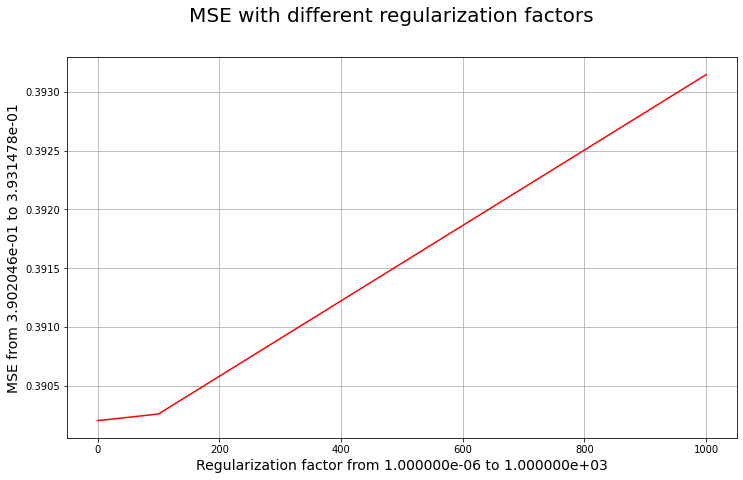

In [25]:
print('MSE with different regularization factors')
fig = plt.figure(figsize = (12, 7))
g = sn.lineplot(x=alphas, y=mean_squared_errors, color = 'r').grid()
fig.suptitle('MSE with different regularization factors', fontsize = 20)
plt.xlabel('Regularization factor from {:e} to {:e}'.format(min(alphas), max(alphas)), fontsize = 14)
plt.ylabel('MSE from {:e} to {:e}'.format(min(mean_squared_errors), max(mean_squared_errors)), fontsize = 14)

# Training and evaluation

In [26]:
%%time
print('Training with {} as learning rate and {} as regularization factor'.format(0.00001, alpha))
spark_rr = SparkRidgeRegression(n_iterations=n_iterations, learning_rate=0.00001, reg_factor=alpha)
now = datetime.now()
spark_rr.fit(labeled_train_df)
print('==> Done in {}\n'.format(datetime.now()-now))

N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Training with 1e-05 as learning rate and 1e-06 as regularization factor


 99% (149 of 150) |##################### | Elapsed Time: 0:03:59 ETA:   0:00:01

From scratch training MSE: 0.37770147579468943
From scratch training RMSE: 0.6145742231778758
From scratch training MAE: 3.781215436239726e-18


100% (150 of 150) |######################| Elapsed Time: 0:04:06 Time:  0:04:06


From scratch training R2: 0.6222861547448344
==> Done in 0:04:06.858793

CPU times: user 5.49 s, sys: 477 ms, total: 5.96 s
Wall time: 4min 6s


In [27]:
%%time
print('Predicting')
predictions = labeled_test_df.map(lambda prediction: spark_rr.predict(prediction))
float_predictions = predictions.map(lambda xs: [float(x) for x in xs])
predictions_df = float_predictions.toDF(['label', 'predictions'])
print('==> Done\n')

Predicting
==> Done

CPU times: user 27.8 ms, sys: 828 µs, total: 28.6 ms
Wall time: 57.1 ms


In [28]:
%%time
root_mean_squared_error = spark_rr.root_mean_squared_error(predictions=predictions)
mean_squared_error = spark_rr.mean_squared_error(predictions=predictions)
mean_absolute_error = spark_rr.mean_absolute_error(predictions=predictions)
r2_score = spark_rr.r2(predictions_df)
print('From scratch test MSE: {}'.format(mean_squared_error))
print('From scratch test RMSE: {}'.format(root_mean_squared_error))
print('From scratch test MAE: {}'.format(mean_absolute_error))
print('From scratch test R2: {}'.format(r2_score))
print('==> Done\n')

From scratch test MSE: 0.38531527115224384
From scratch test RMSE: 0.6207376830451361
From scratch test MAE: 0.007350844331173962
From scratch test R2: 0.6163675467945217
==> Done

CPU times: user 94.9 ms, sys: 12.3 ms, total: 107 ms
Wall time: 2.43 s


Text(0, 0.5, 'Training error')

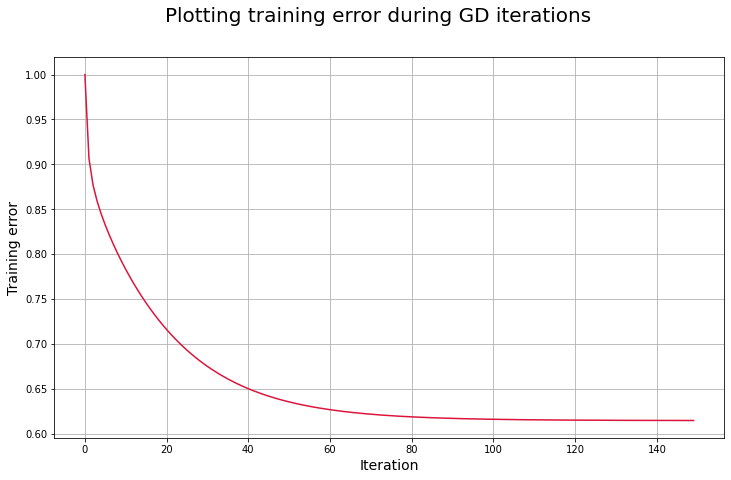

In [29]:
fig = plt.figure(figsize = (12, 7))
g = sn.lineplot(x = np.arange(spark_rr.n_iterations), y = spark_rr.training_errors, color = 'crimson').grid()
fig.suptitle('Plotting training error during GD iterations', fontsize = 20)
plt.xlabel('Iteration', fontsize = 14)
plt.ylabel('Training error', fontsize = 14)

In [30]:
x = np.array(predictions_df.select('label').collect()).flatten()
y = np.array(predictions_df.select('predictions').collect()).flatten()
e = [abs(x[i] - y[i]) for i in range(len(x))]
df = pd.DataFrame(list(zip(x, y, e)), columns = ['label', 'prediction', 'error'])
df

,label,prediction,error
0,-0.707491,-0.588646,0.118846
1,-0.707491,-0.419974,0.287518
2,-0.707491,-0.284524,0.422967
3,-0.707491,-0.296484,0.411008
4,-0.707491,-0.949459,0.241968
...,...,...,...
10274,2.517394,1.231184,1.286210
10275,2.517394,1.301306,1.216088
10276,2.517394,1.190152,1.327242
10277,2.517394,1.030950,1.486445


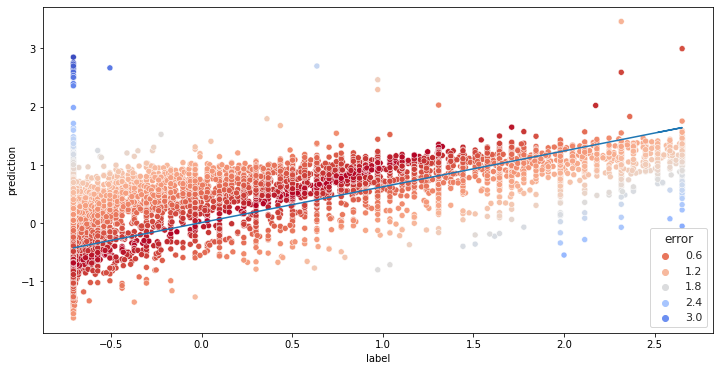

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
m, b = np.polyfit(x, y, 1)
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_theme(style="whitegrid")
sns.scatterplot(data=df, x="label", y="prediction", hue='error', palette='coolwarm_r')

plt.plot(x, m*x + b)

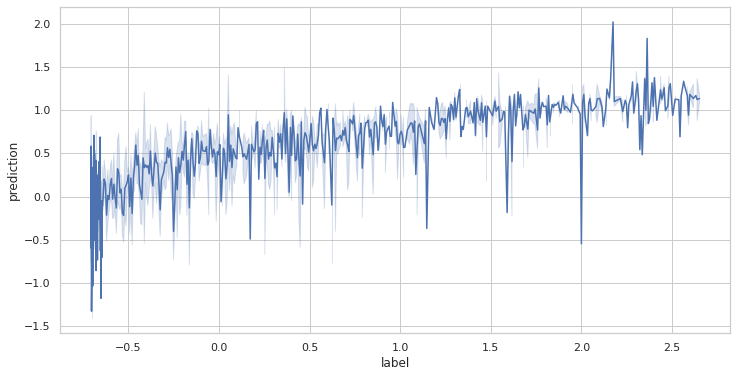

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df, x="label", y="prediction", legend='full')